<a href="https://colab.research.google.com/github/weenslab/coding_for_finance/blob/main/lstm_stock_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Library

In [1]:
!pip install yfinance

In [2]:
from datetime import datetime
from zoneinfo import ZoneInfo
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
import matplotlib.pyplot as plt
from math import sqrt

### Download Dataset

In [3]:
dt_str = '2020-01-01 00:00:00'
dt_obj = datetime.strptime(dt_str,'%Y-%m-%d %H:%M:%S')
dt_obj = dt_obj.replace(tzinfo=ZoneInfo('Asia/Bangkok'))
print(dt_obj)

2020-01-01 00:00:00+07:00


In [4]:
df = yf.download('BBCA.JK', start=dt_obj, interval='1d')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,6695.0,6780.0,6680.0,6690.0,6029.958496,49445000
2020-01-03,6750.0,6800.0,6725.0,6800.0,6129.105469,47755500
2020-01-06,6720.0,6750.0,6690.0,6735.0,6070.517578,27300000
2020-01-07,6735.0,6770.0,6730.0,6740.0,6075.024414,45022500
2020-01-08,6670.0,6745.0,6670.0,6680.0,6020.944824,53692500


In [5]:
df.shape

(1041, 6)

In [6]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Remove Unnecessary Columns

In [7]:
df1 = df.drop(columns=['Open','High','Low','Adj Close','Volume'])
df1.rename(columns={"Close":"Price"}, inplace=True)
df1.head()

,Price
Date,
2020-01-02,6690.0
2020-01-03,6800.0
2020-01-06,6735.0
2020-01-07,6740.0
2020-01-08,6680.0


In [8]:
np1 = df1.to_numpy()
np1.shape

(1041, 1)

In [9]:
np1

array([[6690.],
       [6800.],
       [6735.],
       ...,
       [9525.],
       [9475.],
       [9475.]])

### Data Normalization

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(np1)

In [11]:
scaled

array([[0.38337574],
       [0.40203562],
       [0.39100933],
       ...,
       [0.86429177],
       [0.85581001],
       [0.85581001]])

### Incorporate Timesteps into Data

In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # Input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # Forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # Put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # Drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [13]:
n_timesteps = 1
n_features = 1

In [14]:
reframed = series_to_supervised(scaled, n_timesteps, 1)

In [15]:
reframed

,var1(t-1),var1(t)
1,0.383376,0.402036
2,0.402036,0.391009
3,0.391009,0.391858
4,0.391858,0.381679
5,0.381679,0.391858
...,...,...
1036,0.919423,0.915182
1037,0.915182,0.855810
1038,0.855810,0.864292
1039,0.864292,0.855810


### Train-Test Split

In [16]:
values = reframed.values
n_train = 750
train = values[:n_train,:]
test = values[n_train:,:]

In [17]:
n_obs = n_timesteps * n_features
train_X, train_y = train[:,:n_obs], train[:,n_obs]
test_X, test_y = test[:,:n_obs], test[:,n_obs]
print(train_X.shape, len(train_X), train_y.shape)

(750, 1) 750 (750,)


### Convert into 3D Arrays

In [18]:
train_X = train_X.reshape((train_X.shape[0],n_timesteps,n_features))
test_X = test_X.reshape((test_X.shape[0],n_timesteps,n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(750, 1, 1) (750,) (290, 1, 1) (290,)


### Create LSTM Model

In [19]:
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1],train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(150))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 150)            91200     
                                                                 
 dropout (Dropout)           (None, 1, 150)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 150)            180600    
                                                                 
 dropout_1 (Dropout)         (None, 1, 150)            0         
                                                                 
 lstm_2 (LSTM)               (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 452551 (1.73 MB)
Trainable params: 452551 

### Training

In [20]:
history = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X,test_y), verbose=2, shuffle=False)

Epoch 1/20
24/24 - 8s - loss: 0.0957 - val_loss: 0.0760 - 8s/epoch - 342ms/step
Epoch 2/20
24/24 - 1s - loss: 0.0269 - val_loss: 0.0442 - 801ms/epoch - 33ms/step
Epoch 3/20
24/24 - 1s - loss: 0.0190 - val_loss: 0.0246 - 917ms/epoch - 38ms/step
Epoch 4/20
24/24 - 1s - loss: 0.0181 - val_loss: 0.0169 - 856ms/epoch - 36ms/step
Epoch 5/20
24/24 - 1s - loss: 0.0128 - val_loss: 0.0053 - 840ms/epoch - 35ms/step
Epoch 6/20
24/24 - 1s - loss: 0.0094 - val_loss: 9.9591e-04 - 617ms/epoch - 26ms/step
Epoch 7/20
24/24 - 1s - loss: 0.0048 - val_loss: 4.9630e-04 - 805ms/epoch - 34ms/step
Epoch 8/20
24/24 - 1s - loss: 0.0024 - val_loss: 8.6033e-04 - 651ms/epoch - 27ms/step
Epoch 9/20
24/24 - 1s - loss: 0.0015 - val_loss: 6.9149e-04 - 730ms/epoch - 30ms/step
Epoch 10/20
24/24 - 1s - loss: 0.0016 - val_loss: 7.6074e-04 - 664ms/epoch - 28ms/step
Epoch 11/20
24/24 - 1s - loss: 0.0016 - val_loss: 4.1288e-04 - 657ms/epoch - 27ms/step
Epoch 12/20
24/24 - 1s - loss: 0.0019 - val_loss: 8.8335e-04 - 857ms/epoch

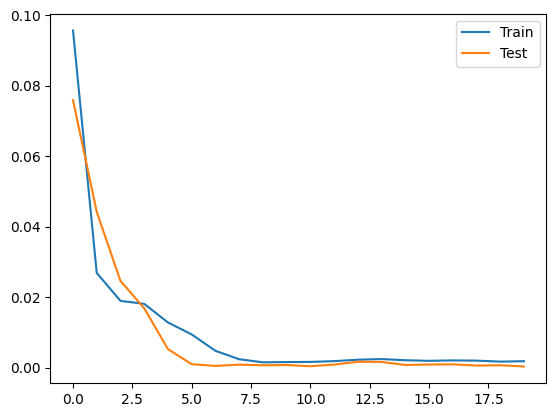

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(['Train','Test'])
plt.show()

### Prediction

In [22]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],n_timesteps*n_features))

10/10 [==============================] - 4s 8ms/step


### Inverse Normalization

In [23]:
inv_yhat = np.concatenate((yhat,test_X[:,-1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [24]:
test_y = test_y.reshape((len(test_y),1))
inv_y = np.concatenate((test_y,test_X[:,-1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Comparison with Ground Truth

In [25]:
inv_y[0:10]

array([8200., 8475., 8700., 8700., 8475., 8500., 8450., 8700., 8725.,
       8850.])

In [26]:
np.round(inv_yhat[0:10])

array([8279., 8254., 8523., 8745., 8745., 8523., 8548., 8499., 8745.,
       8769.])

In [27]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 108.843


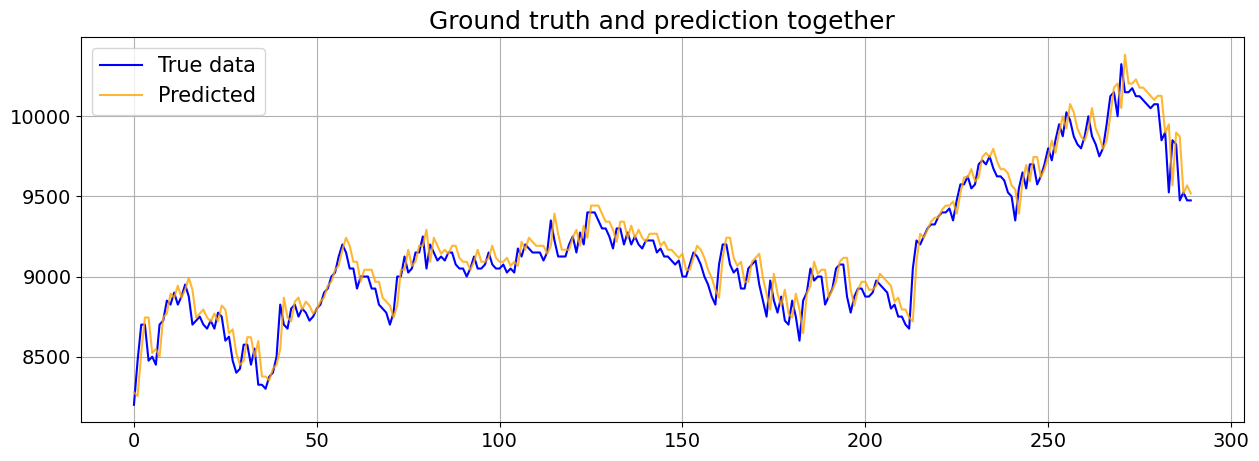

In [28]:
plt.figure(figsize=(15,5))
plt.title("Ground truth and prediction together", fontsize=18)
plt.plot(inv_y, c='blue')
plt.plot(inv_yhat, c='orange', alpha=0.8)
plt.legend(['True data','Predicted'], fontsize=15)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()